# Visualization and inspection of generated text embeddings for BraTS dataset

This notebook loads per-case `.npz` text embeddings and helps inspect:
- embedding value distribution
- embedding norms
- 2D projection (UMAP / t-SNE / PCA)
- cosine similarity structure


In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

try:
    import umap  # pip install umap-learn
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False


In [2]:
def load_embeddings(emb_folder_path=None, max_files=None):
    # ---- Load all .npz embeddings ----
    npz_files = sorted(Path(emb_folder_path).glob('*.npz'))
    if max_files is not None:
        npz_files = npz_files[:max_files]

    if len(npz_files) == 0:
        raise RuntimeError(f'No .npz files found in {emb_folder_path}')

    emb_list, case_ids = [], []
    for f in npz_files:
        data = np.load(f)
        if 'embedding' in data:
            emb = data['embedding']
        elif len(data.files) == 1:
            emb = data[data.files[0]]
        else:
            raise KeyError(f"No 'embedding' key in {f}, available keys: {data.files}")

        emb = np.asarray(emb, dtype=np.float32).reshape(-1)
        emb_list.append(emb)
        case_ids.append(f.stem)

    X = np.stack(emb_list, axis=0)  # [N, D]
    N, D = X.shape
    print(f'Loaded {N} embeddings with dim={D}')
    print('Example case IDs:', case_ids[:5])
    return X


def show_dist_statistics(X):
    norms = np.linalg.norm(X, axis=1)
    print(f'Embedding value range: min={X.min():.4f}, max={X.max():.4f}')
    print(f'Embedding mean/std: mean={X.mean():.4f}, std={X.std():.4f}')
    print(f'L2 norms: min={norms.min():.4f}, mean={norms.mean():.4f}, max={norms.max():.4f}')

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(X.ravel(), bins=100, alpha=0.85)
    axes[0].set_title('Distribution of embedding values (all dims/all samples)')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Count')

    axes[1].hist(norms, bins=60, alpha=0.85)
    axes[1].set_title('Distribution of embedding L2 norms')
    axes[1].set_xlabel('L2 norm')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

def projection_2d(X, method, seed):
    # ---- 2D projection for visual inspection ----
    Xs = StandardScaler().fit_transform(X)
    Xp = PCA(n_components=min(50, Xs.shape[1]), random_state=seed).fit_transform(Xs)

    if method == 'umap' and not HAS_UMAP:
        print('UMAP not installed -> falling back to pca2. Install with: pip install umap-learn')
        method = 'pca2'

    if method == 'pca2':
        Z = PCA(n_components=2, random_state=seed).fit_transform(Xp)
    elif method == 'tsne':
        perplexity = min(30, max(5, (len(Xp) - 1) // 3))
        Z = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='pca', random_state=seed).fit_transform(Xp)
    elif method == 'umap':
        n_neighbors = min(30, max(5, len(Xp) - 1))
        Z = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.1, metric='cosine', random_state=seed).fit_transform(Xp)
    else:
        raise ValueError("method must be 'umap', 'tsne', or 'pca2'")

    plt.figure(figsize=(7, 6))
    plt.scatter(Z[:, 0], Z[:, 1], s=10, alpha=0.8)
    plt.title(f'Text embeddings ({method})')
    plt.xlabel('dim-1')
    plt.ylabel('dim-2')
    plt.tight_layout()
    plt.show()

def plot_similarity_matrix(X):
    normalized_X = torch.nn.functional.normalize(torch.tensor(X, dtype=torch.float32), dim=-1).cpu().numpy()
    similarity_matrix = normalized_X @ normalized_X.T

    off_diag = similarity_matrix[~np.eye(similarity_matrix.shape[0], dtype=bool)]
    print(f'Cosine similarity (off-diagonal): min={off_diag.min():.4f}, mean={off_diag.mean():.4f}, max={off_diag.max():.4f}')

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    im = axes[0].imshow(similarity_matrix, cmap='viridis')
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
    axes[0].set_title('Cosine Similarity Matrix')
    axes[0].set_xlabel('Case index')
    axes[0].set_ylabel('Case index')

    axes[1].hist(off_diag, bins=80, alpha=0.85)
    axes[1].set_title('Distribution of pairwise cosine similarities (off-diagonal)')
    axes[1].set_xlabel('Cosine similarity')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()
    
def remove_top1_pc_sklearn(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    X = np.asarray(X, dtype=np.float32)
    Xc = X - X.mean(axis=0, keepdims=True)

    pca = PCA(n_components=1, svd_solver="full")
    pca.fit(Xc)
    u = pca.components_[0]              # [D], unit vector

    Xc2 = Xc - (Xc @ u[:, None]) * u[None, :]
    Xc2 = Xc2 / (np.linalg.norm(Xc2, axis=1, keepdims=True) + eps)
    return Xc2
    

In [3]:
# ---- Configuration ----

max_files = None      # e.g. 500 for quick preview, or None for all
seed = 0
method = 'umap'       # 'umap' | 'tsne' | 'pca2'

np.random.seed(seed)


## RG embeddings

#### BioBERT

In [34]:
emb_folder = '/leonardo_work/IscrC_narc2/reports_project/BRATS2023_Training_nifti/report_RG_biobert'

X = load_embeddings(emb_folder)

Loaded 230 embeddings with dim=768
Example case IDs: ['BraTS-GLI-00006-000', 'BraTS-GLI-00012-000', 'BraTS-GLI-00014-001', 'BraTS-GLI-00017-000', 'BraTS-GLI-00021-000']


Embedding value range: min=-8.8038, max=1.0682
Embedding mean/std: mean=-0.0091, std=0.3694
L2 norms: min=9.7910, mean=10.2393, max=10.5050


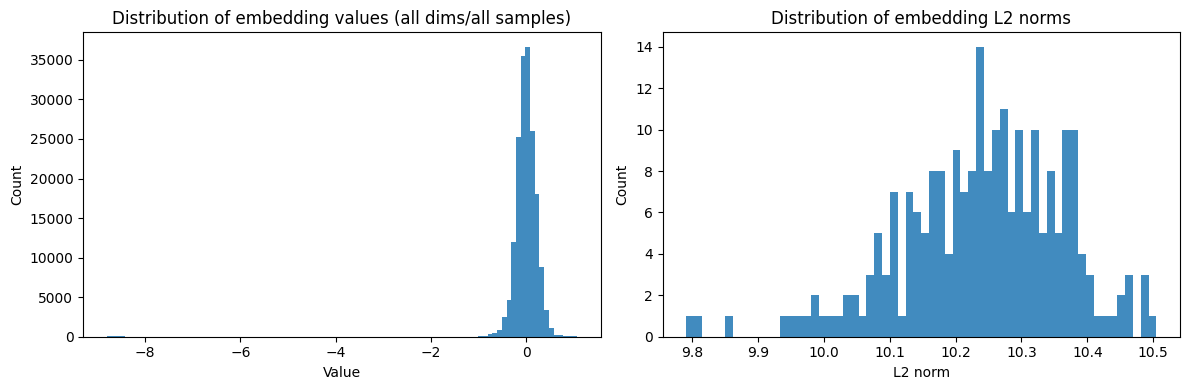

In [27]:
show_dist_statistics(X)

/leonardo/home/userexternal/ldelgaud/.conda/envs/timemil/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


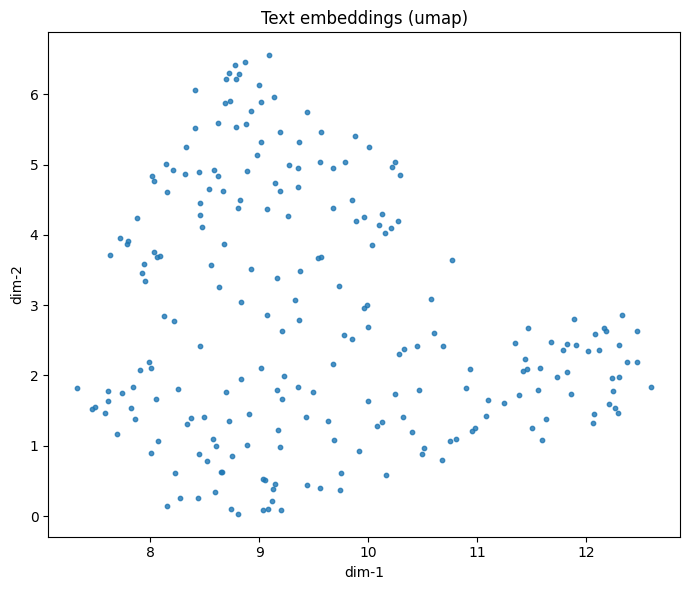

In [ ]:
projection_2d(X, method, seed)

Cosine similarity (off-diagonal): min=0.9492, mean=0.9832, max=0.9975


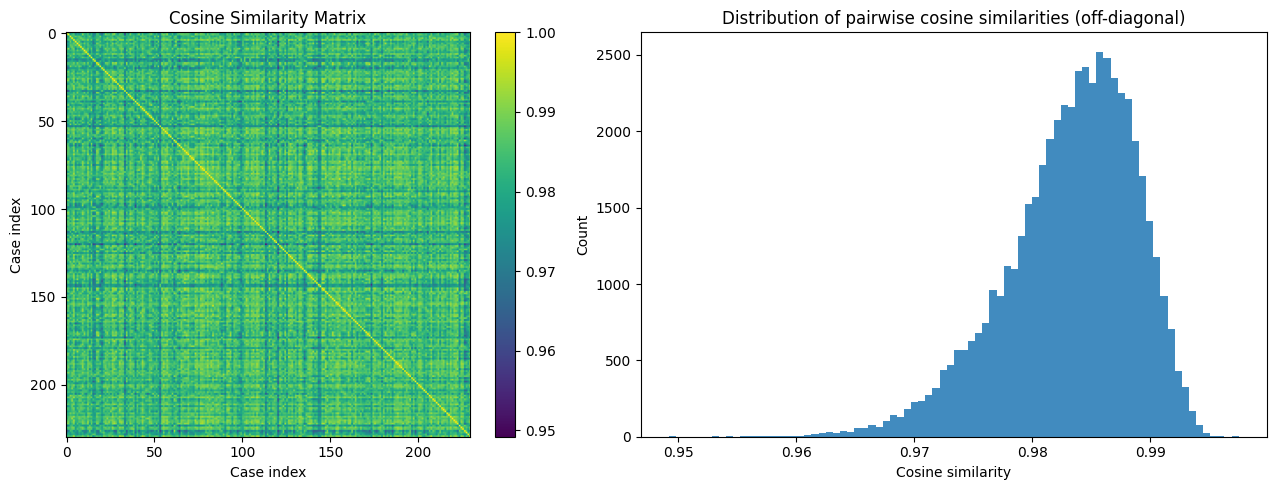

In [35]:
plot_similarity_matrix(X)

#### BioClinicalBERT

In [36]:
emb_folder = '/leonardo_work/IscrC_narc2/reports_project/BRATS2023_Training_nifti/report_RG_bioclinicalbert'

X = load_embeddings(emb_folder)

Loaded 230 embeddings with dim=768
Example case IDs: ['BraTS-GLI-00006-000', 'BraTS-GLI-00012-000', 'BraTS-GLI-00014-001', 'BraTS-GLI-00017-000', 'BraTS-GLI-00021-000']


Embedding value range: min=-9.7503, max=0.9644
Embedding mean/std: mean=-0.0077, std=0.4036
L2 norms: min=10.9308, mean=11.1857, max=11.4996


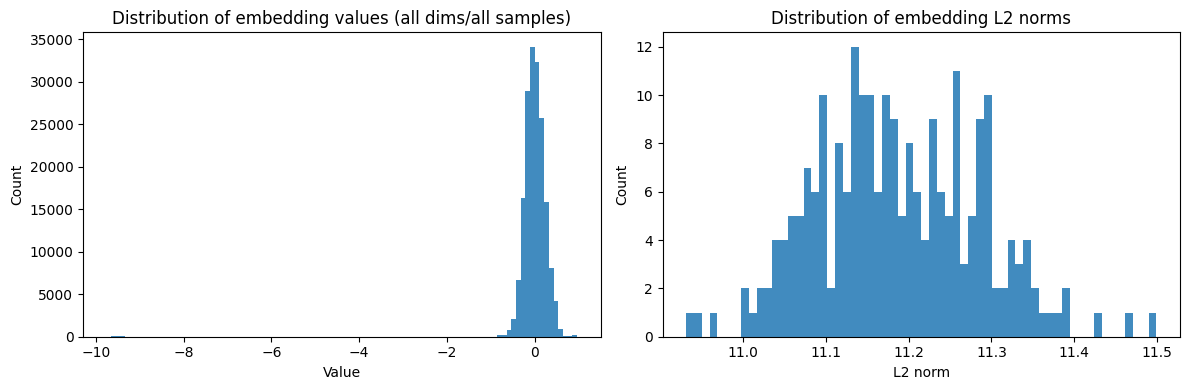

In [37]:
show_dist_statistics(X)

/leonardo/home/userexternal/ldelgaud/.conda/envs/timemil/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


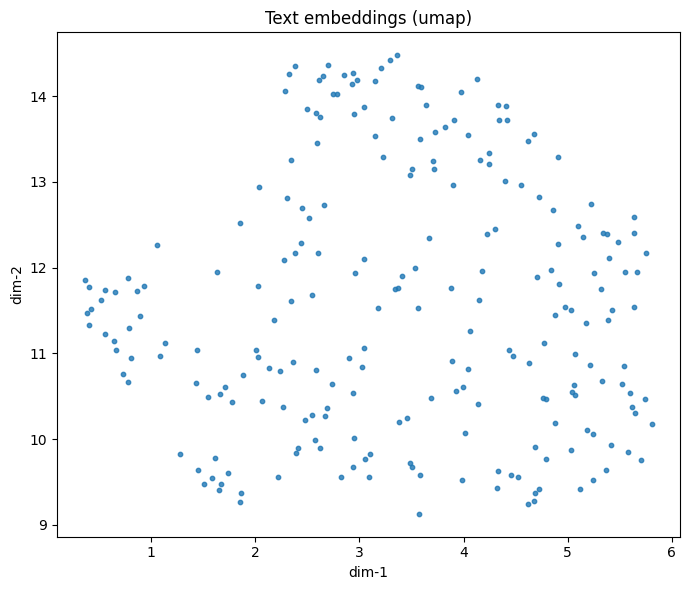

In [38]:
projection_2d(X, method, seed)

Cosine similarity (off-diagonal): min=0.9598, mean=0.9850, max=0.9973


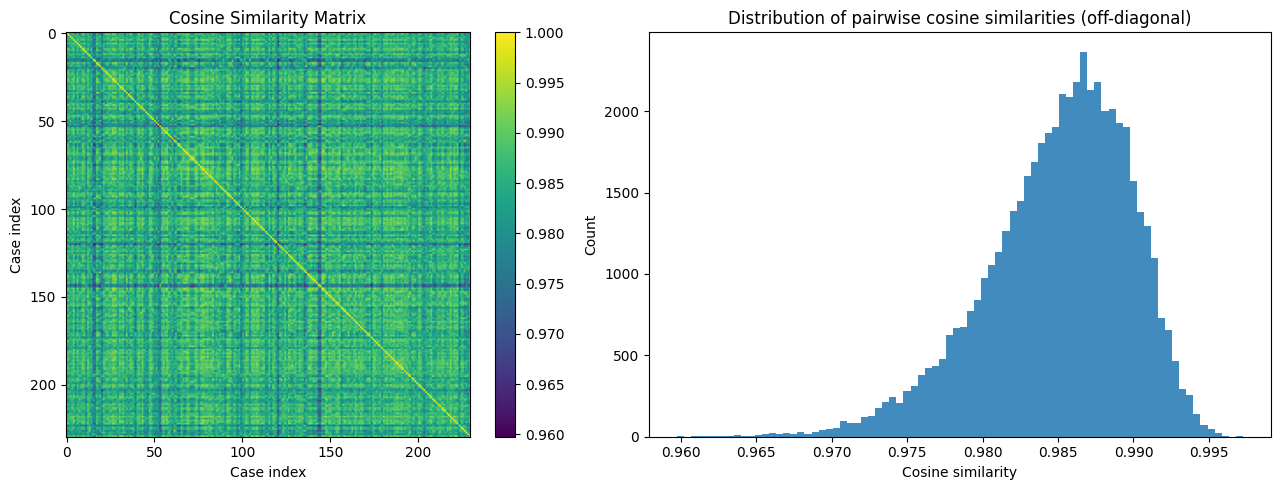

In [39]:
plot_similarity_matrix(X)

## BraTS-Report (ours)

BioBERT

In [5]:
emb_folder = '/leonardo_work/IscrC_narc2/reports_project/BRATS2023_Training_nifti/report_BraTS-Report_biobert'

X = load_embeddings(emb_folder)

Loaded 256 embeddings with dim=768
Example case IDs: ['BraTS-GLI-00000-000', 'BraTS-GLI-00002-000', 'BraTS-GLI-00003-000', 'BraTS-GLI-00005-000', 'BraTS-GLI-00006-000']


Embedding value range: min=-8.3325, max=0.9849
Embedding mean/std: mean=-0.0095, std=0.3489
L2 norms: min=9.4064, mean=9.6721, max=9.8907


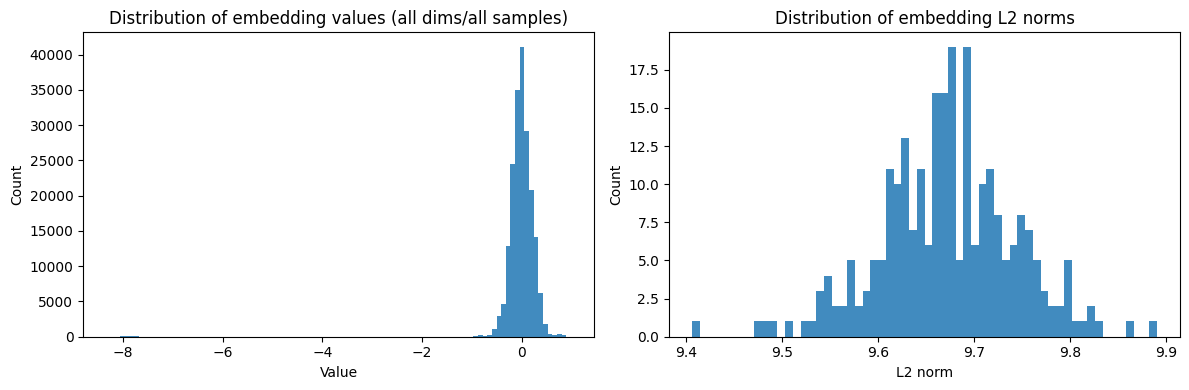

In [6]:
show_dist_statistics(X)

/leonardo/home/userexternal/ldelgaud/.conda/envs/timemil/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


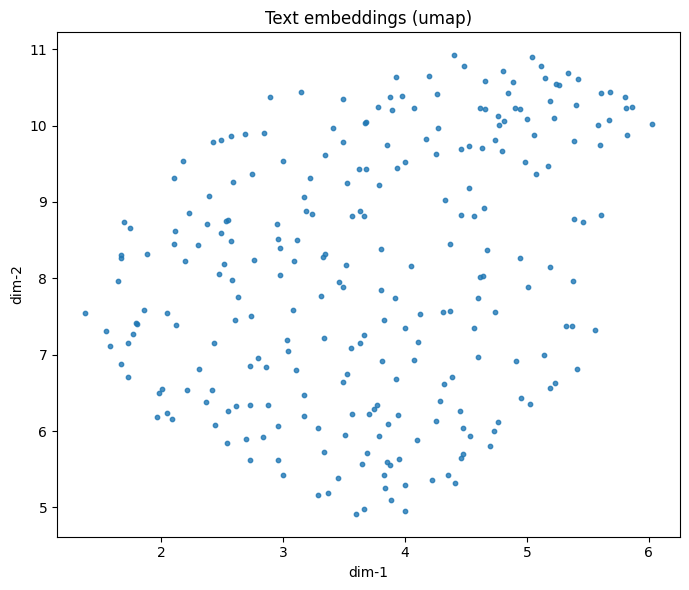

In [42]:
projection_2d(X, method, seed)

Cosine similarity (off-diagonal): min=0.9534, mean=0.9892, max=0.9997


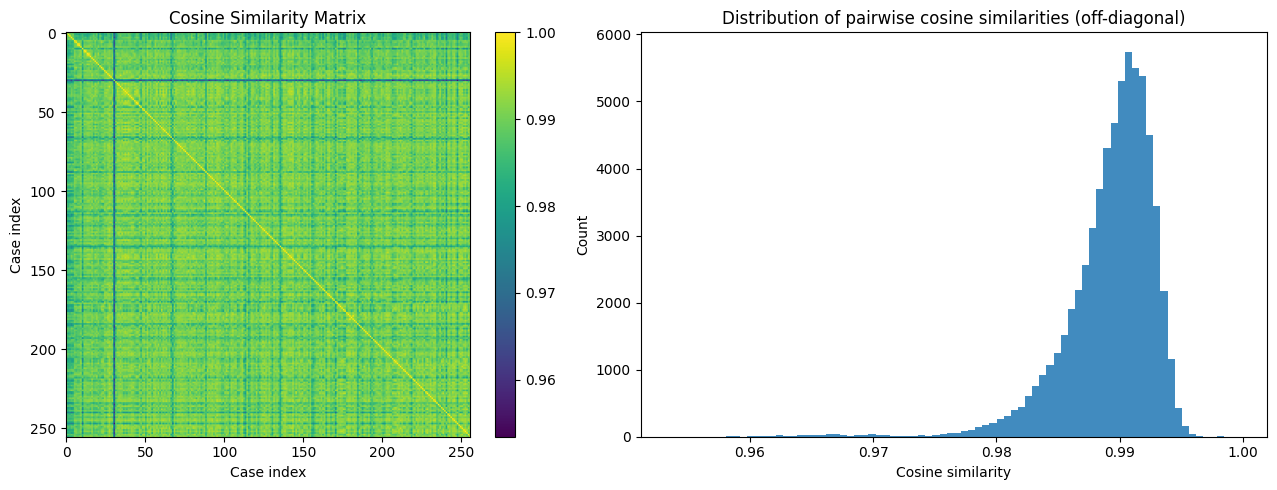

In [7]:
plot_similarity_matrix(X)

In [8]:
norms = np.linalg.norm(X, axis=1)
print(norms.min(), norms.mean(), norms.max(), norms.std())


9.406372 9.672102 9.890673 0.07088323


In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20).fit(X)
print("Top-1 explained:", pca.explained_variance_ratio_[0])
print("Top-5 explained:", pca.explained_variance_ratio_[:5].sum())


Top-1 explained: 0.1561655
Top-5 explained: 0.37035242


In [11]:
X_proc = remove_top1_pc_sklearn(X)

norms = np.linalg.norm(X_proc, axis=1)
print(norms.min(), norms.mean(), norms.max(), norms.std())


0.9999999 1.0 1.0000001 3.290087e-08


Cosine similarity (off-diagonal): min=-0.4608, mean=-0.0035, max=0.9571


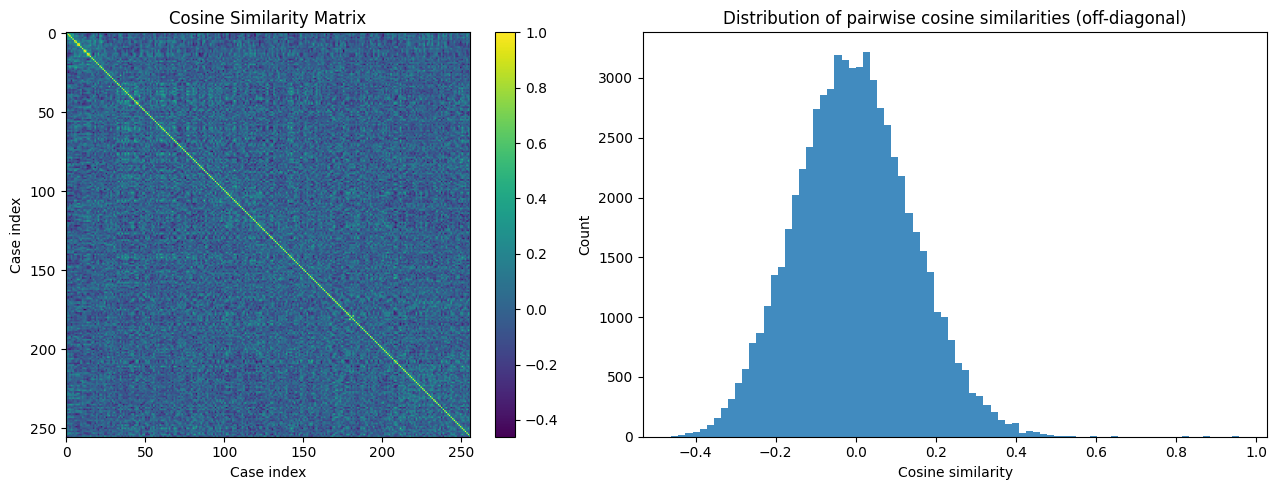

In [12]:
plot_similarity_matrix(X_proc)

In [17]:
import os
import glob
import numpy as np

input_folder = "/leonardo_work/IscrC_narc2/reports_project/BRATS2023_Training_nifti/report_RG_biobert"
output_folder = "/leonardo_work/IscrC_narc2/reports_project/BRATS2023_Training_nifti/reduced_reports/report_RG_biobert_reduced"

os.makedirs(output_folder, exist_ok=True)

# Load files in deterministic order
files = sorted(glob.glob(os.path.join(input_folder, "*.npz")))

# Load original embeddings
X = np.stack([np.load(f)["embedding"] for f in files])

# ---- APPLY PC REMOVAL HERE ----
X_reduced = remove_top1_pc_sklearn(X)

# ---- SAVE BACK INDIVIDUALLY ----
for file_path, emb in zip(files, X_reduced):
    filename = os.path.basename(file_path)
    out_path = os.path.join(output_folder, filename)
    np.savez_compressed(out_path, embedding=emb.astype(np.float32))

print(f"Saved {len(files)} reduced embeddings to {output_folder}")


Saved 230 reduced embeddings to /leonardo_work/IscrC_narc2/reports_project/BRATS2023_Training_nifti/reduced_reports/report_RG_biobert_reduced


ClinicalBERT

In [44]:
emb_folder = '/leonardo_work/IscrC_narc2/reports_project/BRATS2023_Training_nifti/report_BraTS-Report_clinicalbert'

X = load_embeddings(emb_folder)

Loaded 256 embeddings with dim=768
Example case IDs: ['BraTS-GLI-00000-000', 'BraTS-GLI-00002-000', 'BraTS-GLI-00003-000', 'BraTS-GLI-00005-000', 'BraTS-GLI-00006-000']


Embedding value range: min=-2.3031, max=1.1960
Embedding mean/std: mean=-0.0058, std=0.2912
L2 norms: min=7.6380, mean=8.0709, max=8.5823


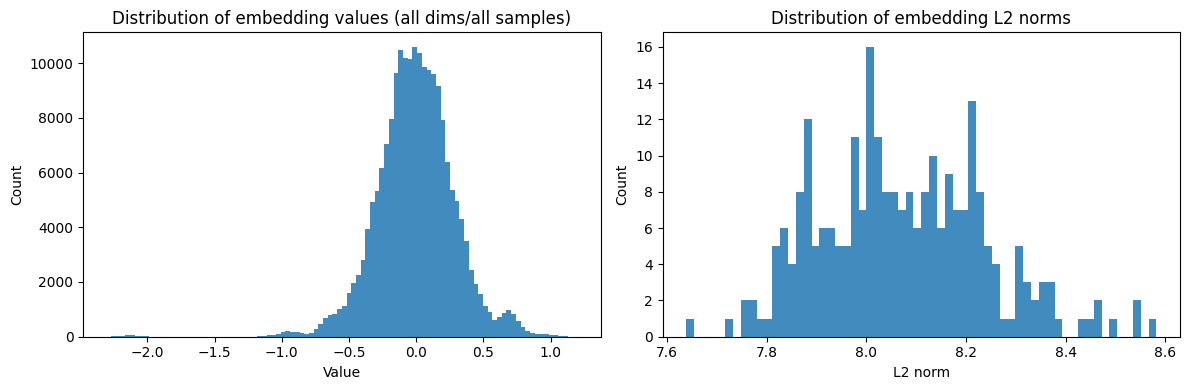

In [45]:
show_dist_statistics(X)

/leonardo/home/userexternal/ldelgaud/.conda/envs/timemil/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


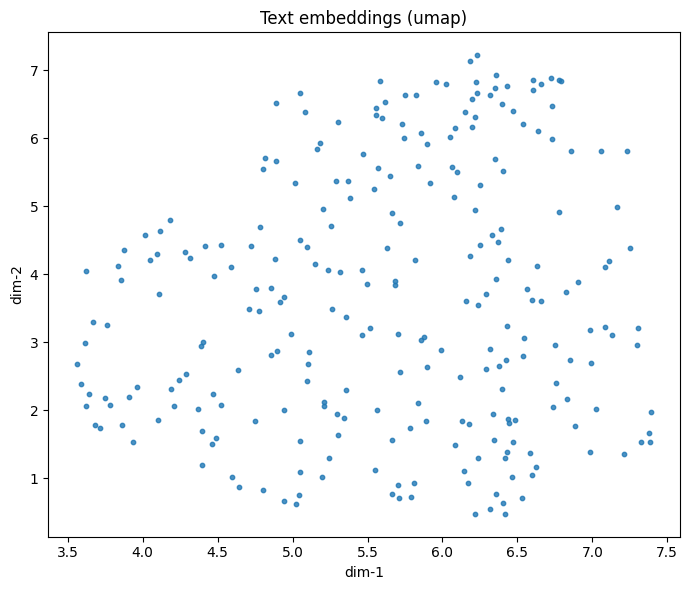

In [46]:
projection_2d(X, method, seed)

Cosine similarity (off-diagonal): min=0.9402, mean=0.9823, max=0.9997


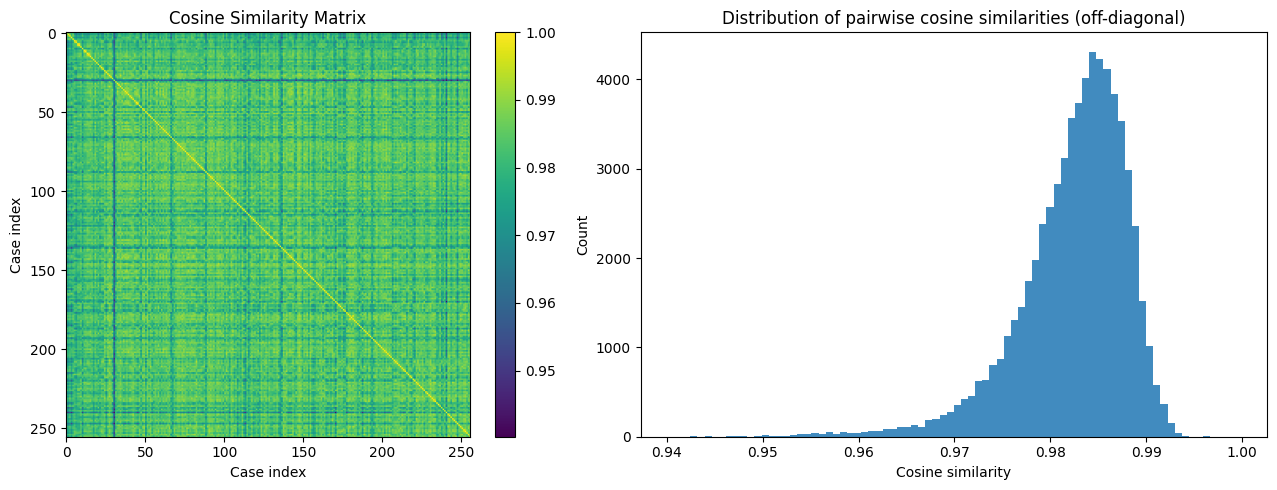

In [47]:
plot_similarity_matrix(X)

BioClinicalBERT

In [1]:
emb_folder = '/leonardo_work/IscrC_narc2/reports_project/BRATS2023_Training_nifti/report_BraTS-Report_bioclinicalbert'

X = load_embeddings(emb_folder)

NameError: name 'load_embeddings' is not defined

Embedding value range: min=-9.4544, max=0.9947
Embedding mean/std: mean=-0.0080, std=0.4037
L2 norms: min=10.8960, mean=11.1902, max=11.3914


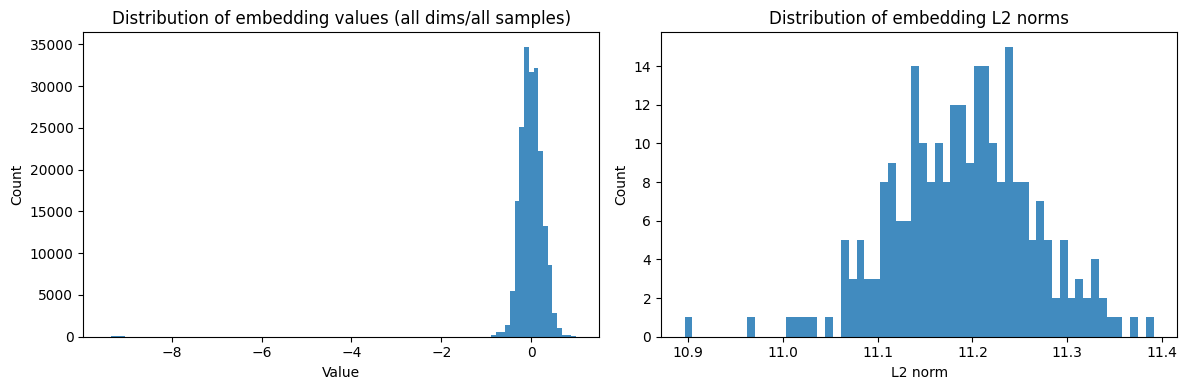

In [49]:
show_dist_statistics(X)

/leonardo/home/userexternal/ldelgaud/.conda/envs/timemil/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


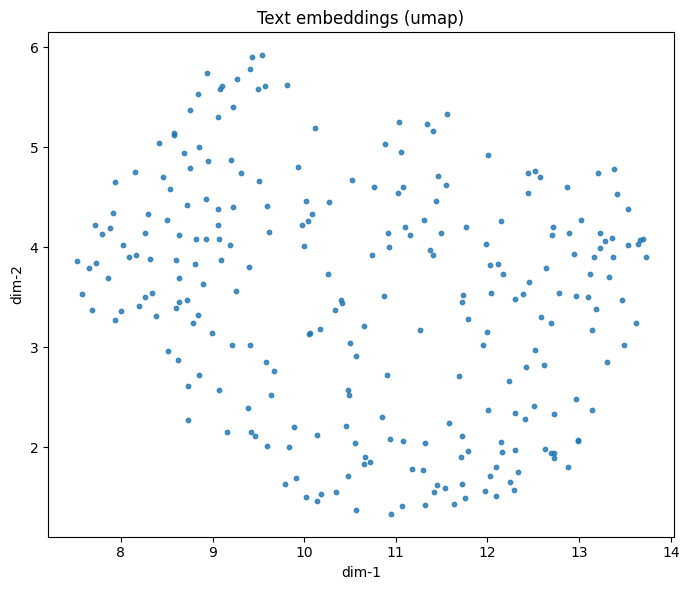

In [50]:
projection_2d(X, method, seed)

Cosine similarity (off-diagonal): min=0.9665, mean=0.9901, max=0.9996


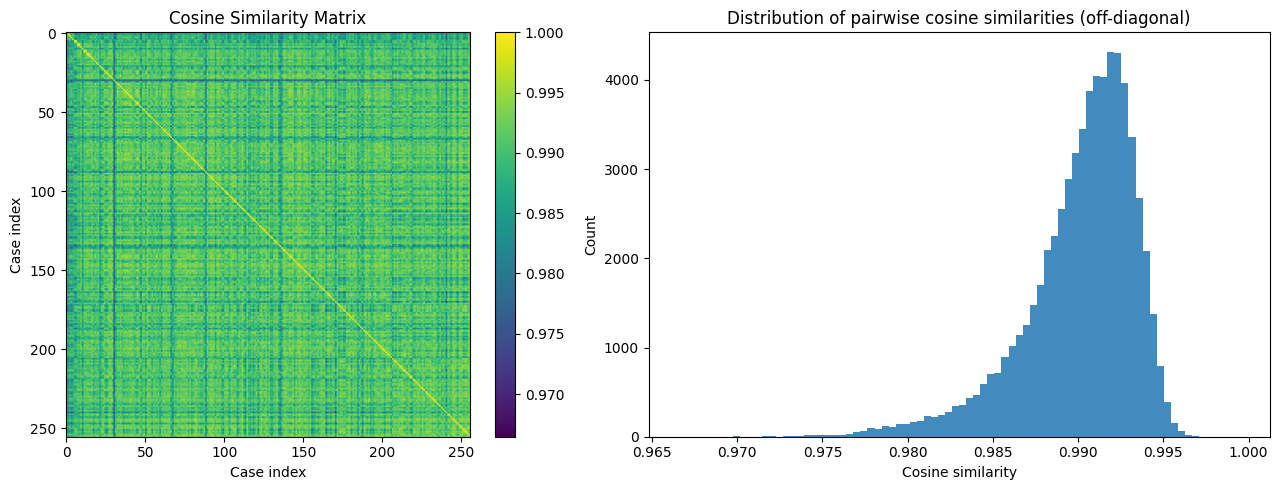

In [51]:
plot_similarity_matrix(X)

BioClinical-ModernBERT

In [53]:
emb_folder = '/leonardo_work/IscrC_narc2/reports_project/BRATS2023_Training_nifti/report_BraTS-Report_bioclinicalbert_chunked'

X = load_embeddings(emb_folder)

Loaded 256 embeddings with dim=768
Example case IDs: ['BraTS-GLI-00000-000', 'BraTS-GLI-00002-000', 'BraTS-GLI-00003-000', 'BraTS-GLI-00005-000', 'BraTS-GLI-00006-000']


Embedding value range: min=-9.4544, max=0.9947
Embedding mean/std: mean=-0.0080, std=0.4028
L2 norms: min=10.9099, mean=11.1655, max=11.3672


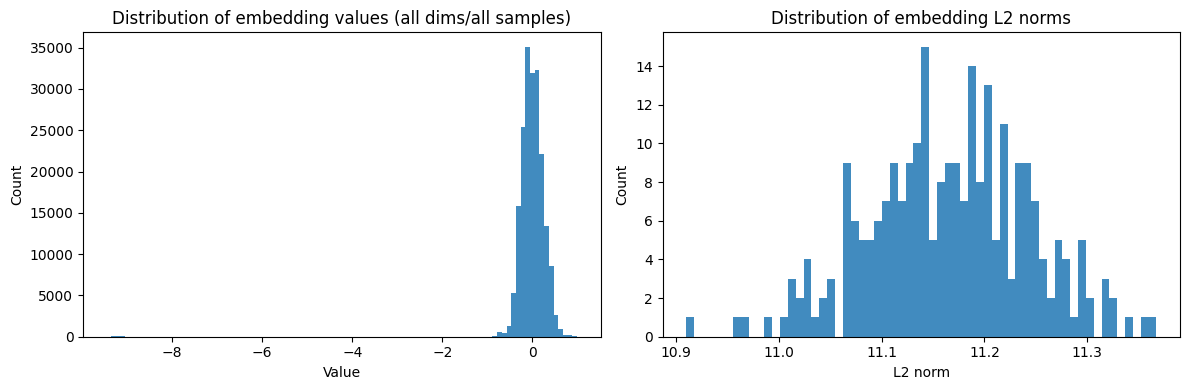

In [54]:
show_dist_statistics(X)

/leonardo/home/userexternal/ldelgaud/.conda/envs/timemil/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


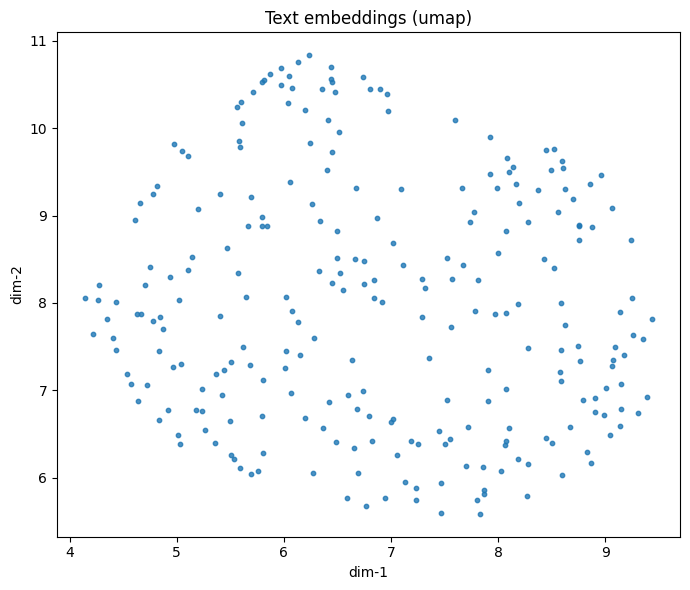

In [55]:
projection_2d(X, method, seed)

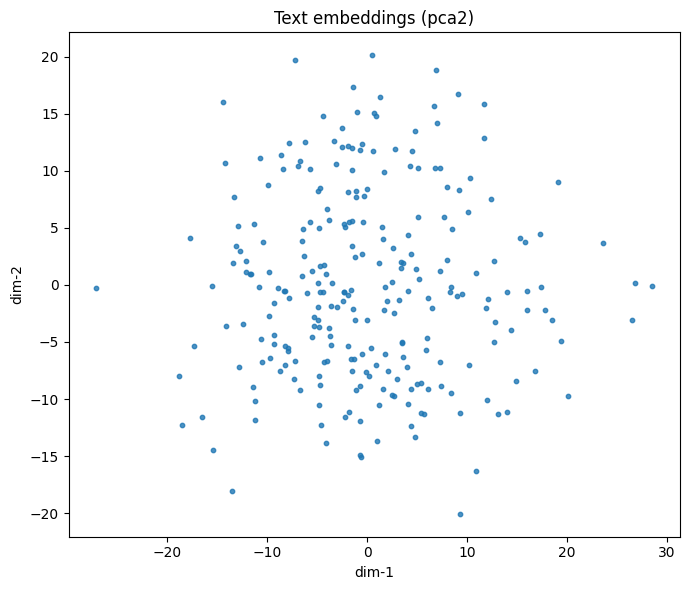

In [57]:
projection_2d(X, "pca2", seed)

In [58]:
projection_2d(X, "tsne", seed)

: 

Cosine similarity (off-diagonal): min=0.9712, mean=0.9905, max=0.9996


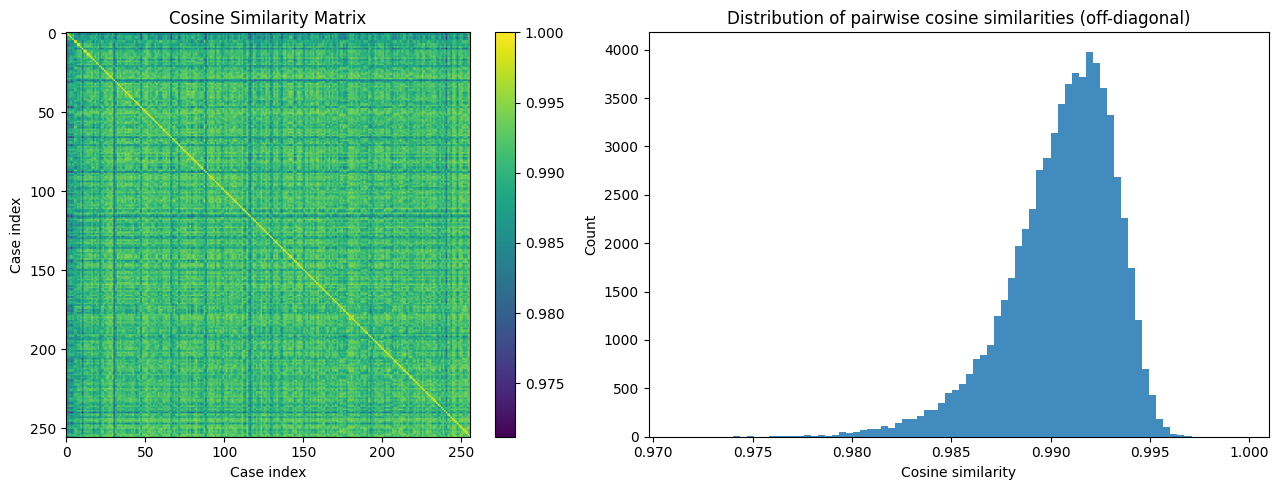

In [56]:
plot_similarity_matrix(X)

## QaTaCOV

BioBERT

In [4]:
emb_path = "/leonardo_work/IscrC_narc2/reports_project/QaTa-COV19/Text_Embeddings/BioBERT/CLS/reports_emb.npy"
X = np.load(emb_path)

X = np.squeeze(X)
assert X.ndim == 2, f"Expected [N, D], got {X.shape}"

print("Loaded BioBERT CLS embeddings:", X.shape)

Loaded BioBERT CLS embeddings: (283, 768)


Embedding value range: min=-10.1748, max=1.5829
Embedding mean/std: mean=-0.0078, std=0.4688
L2 norms: min=12.8018, mean=12.9930, max=13.0894


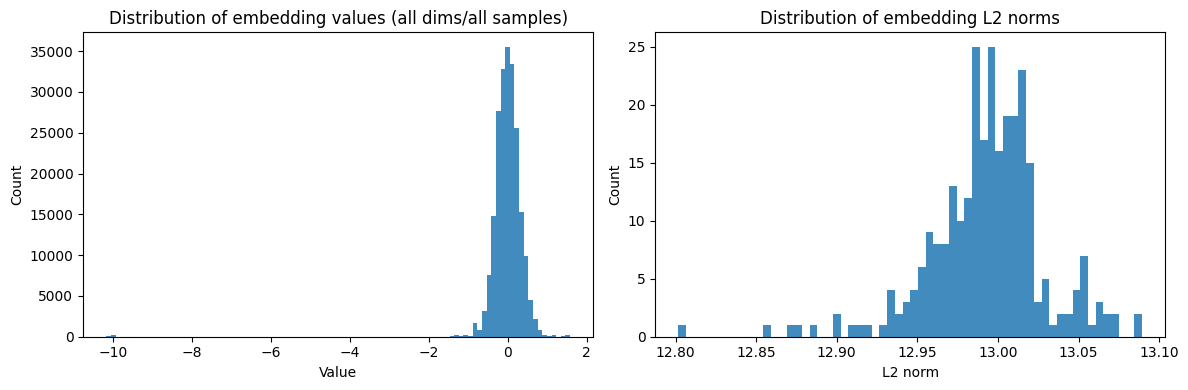

In [5]:
show_dist_statistics(X)

/leonardo/home/userexternal/ldelgaud/.conda/envs/timemil/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


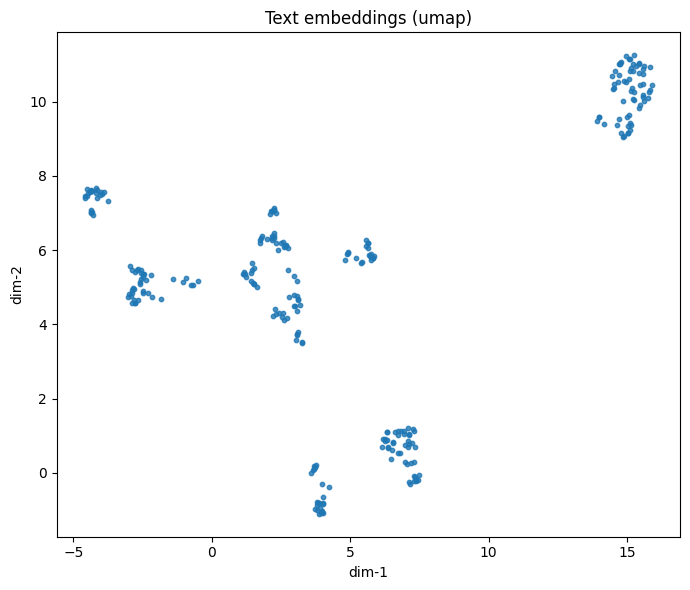

In [7]:
method = "umap"
seed = 0

projection_2d(X, method, seed)

Cosine similarity (off-diagonal): min=0.8880, mean=0.9927, max=1.0000


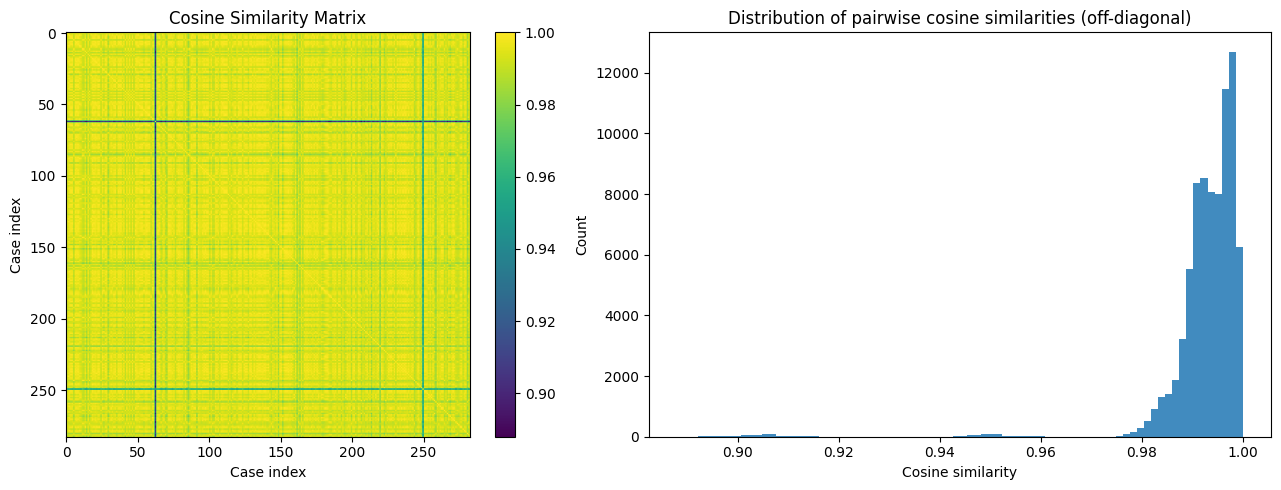

In [8]:
plot_similarity_matrix(X)

In [9]:
pca = PCA(n_components=20).fit(X)
print("Top-1 explained:", pca.explained_variance_ratio_[0])
print("Top-5 explained:", pca.explained_variance_ratio_[:5].sum())

Top-1 explained: 0.26331583
Top-5 explained: 0.71693903


In [10]:
X_proc = remove_top1_pc_sklearn(X)

norms = np.linalg.norm(X_proc, axis=1)
print(norms.min(), norms.mean(), norms.max(), norms.std())

0.99999994 1.0 1.0 3.1690703e-08


Cosine similarity (off-diagonal): min=-0.8496, mean=0.0061, max=1.0000


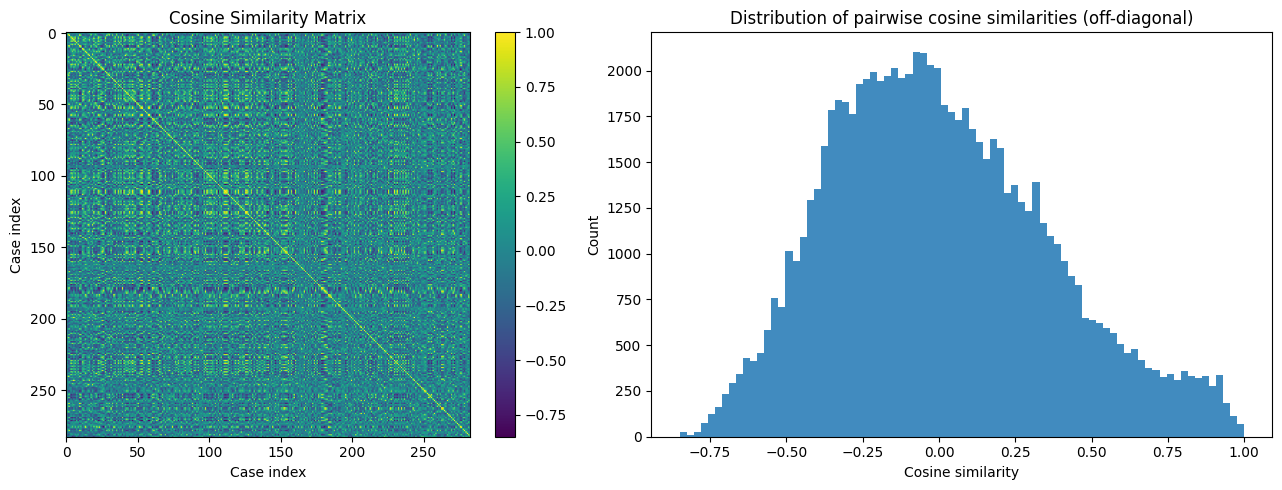

In [11]:
plot_similarity_matrix(X_proc)

In [16]:
import os

save_directory = "/leonardo_work/IscrC_narc2/reports_project/QaTa-COV19/Text_Embeddings/BioBERT/reduced"
emb_path = os.path.join(save_directory, "reports_emb.npy")
np.save(emb_path, X_proc)

#### BioClinical-ModernBERT

In [4]:
emb_folder = '/leonardo_work/IscrC_narc2/reports_project/BRATS2023_Training_nifti/BraTS-Report/base/BioClinical-ModernBERT/clinical'

X = load_embeddings(emb_folder)

Loaded 257 embeddings with dim=768
Example case IDs: ['BraTS-GLI-00000-000', 'BraTS-GLI-00002-000', 'BraTS-GLI-00003-000', 'BraTS-GLI-00005-000', 'BraTS-GLI-00006-000']


Embedding value range: min=-2.9916, max=2.9601
Embedding mean/std: mean=0.0006, std=0.7456
L2 norms: min=19.4149, mean=20.6558, max=22.2807


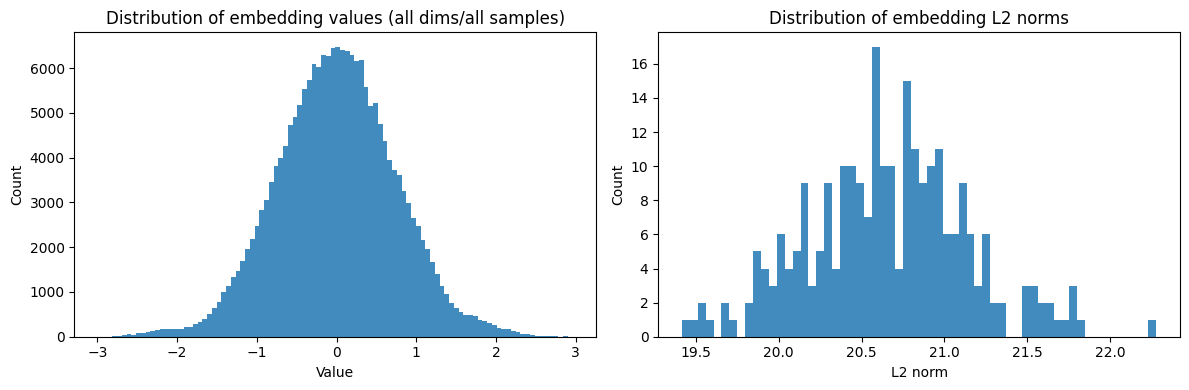

In [5]:
show_dist_statistics(X)

/leonardo/home/userexternal/ldelgaud/.conda/envs/timemil/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


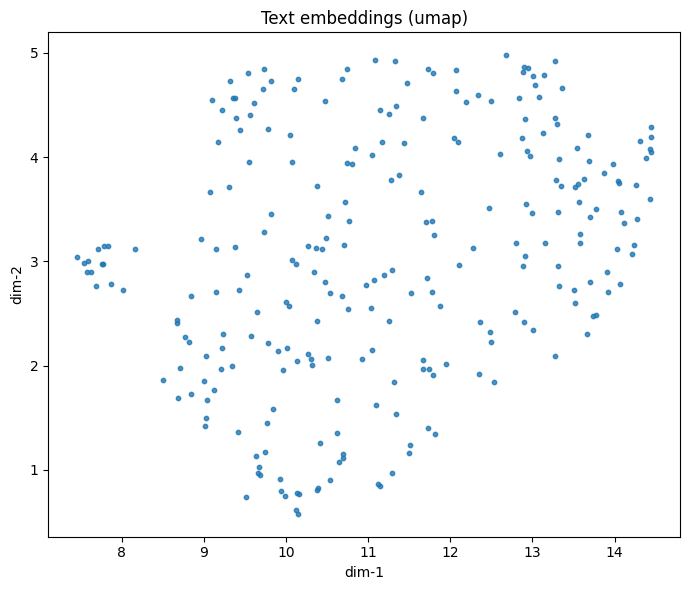

In [6]:
projection_2d(X, method, seed)

Cosine similarity (off-diagonal): min=0.6194, mean=0.8831, max=0.9996


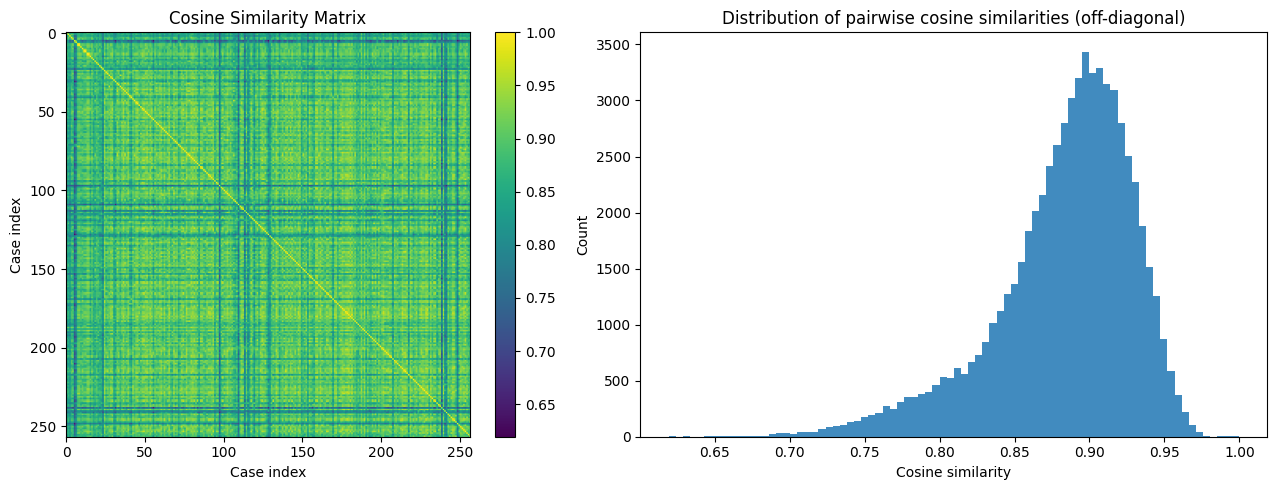

In [7]:
plot_similarity_matrix(X)

In [8]:
pca = PCA(n_components=20).fit(X)
print("Top-1 explained:", pca.explained_variance_ratio_[0])
print("Top-5 explained:", pca.explained_variance_ratio_[:5].sum())

Top-1 explained: 0.11475209
Top-5 explained: 0.36426637


In [9]:
X_proc = remove_top1_pc_sklearn(X)

norms = np.linalg.norm(X_proc, axis=1)
print(norms.min(), norms.mean(), norms.max(), norms.std())

0.9999999 1.0 1.0000001 3.304662e-08


Cosine similarity (off-diagonal): min=-0.5281, mean=-0.0032, max=0.9920


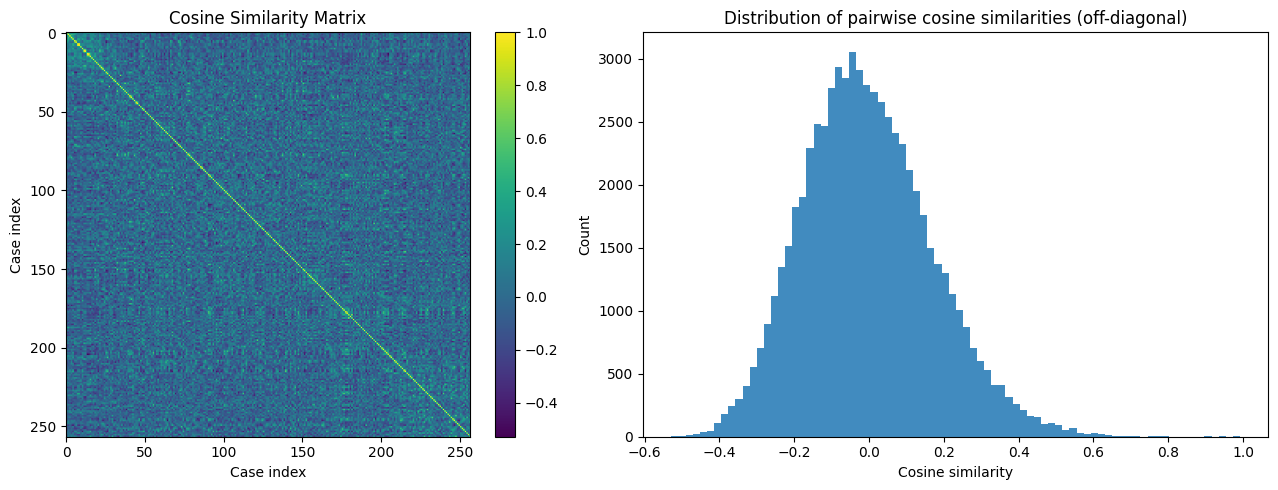

In [10]:
plot_similarity_matrix(X_proc)